In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import Risk_Kit as erk
import numpy as np
import pandas as pd

ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_return()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
risky_r = ind_return["2000":][["Steel","Fin","Beer"]]

In [5]:
safe_r = pd.DataFrame().reindex_like(risky_r)

In [6]:
safe_r[:] = 0.03/12
start = 1000
floor = 0.8

### 1. Cushion - (Asset Value minus Floor Value)
### 2. Compute an Allocation to Safe and Risky Assets --> m*risk budget
### 3. Recompute the Asset Value based on the returns 

In [7]:
def compound1(r):
    return (1+r).prod()-1
def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [8]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [9]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [10]:
%timeit compound1(risky_r)

424 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%timeit compound2(risky_r)

408 µs ± 8.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
dates = risky_r.index
n_steps = len(dates)
account_value = start 
floor_value = start*floor
m = 3 
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w,1)
    risky_w = np.maximum(risky_w,0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    ## update the account value for this time step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    #save the value so we could plot it
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value



In [13]:
account_history

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489
...,...,...,...
2018-08,1078.784329,2461.732061,4155.508933
2018-09,1073.786842,2414.220632,4163.404400
2018-10,979.057951,2282.645608,4098.038951
2018-11,964.047446,2348.614066,4335.315406


In [14]:
risky_wealth = start*(1+risky_r).cumprod()

<AxesSubplot:>

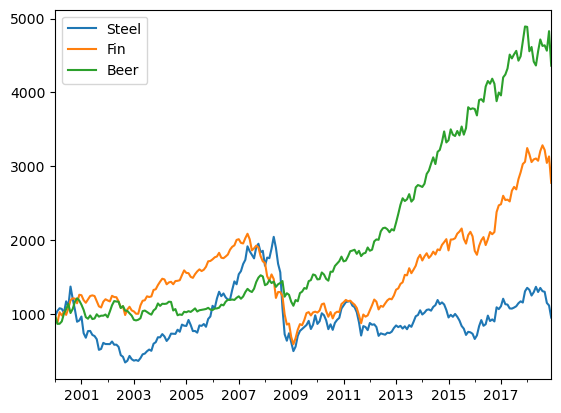

In [15]:
risky_wealth.plot()

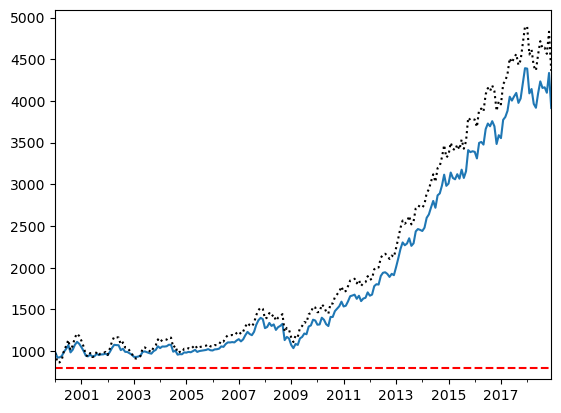

In [16]:
ax = account_history["Beer"].plot()
risky_wealth["Beer"].plot(ax=ax, style="k:")
ax.axhline(y=floor_value,color ="r", linestyle="--")

<AxesSubplot:>

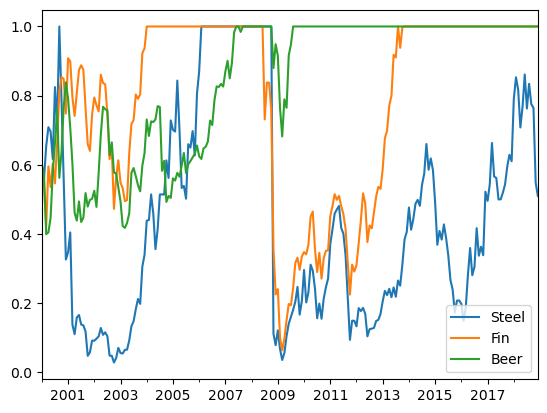

In [17]:
risky_w_history.plot()

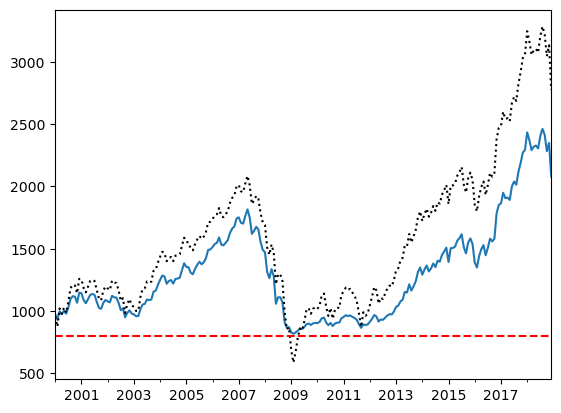

In [18]:
ind = "Fin"
ax = account_history[ind].plot()
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value,color ="r", linestyle="--")

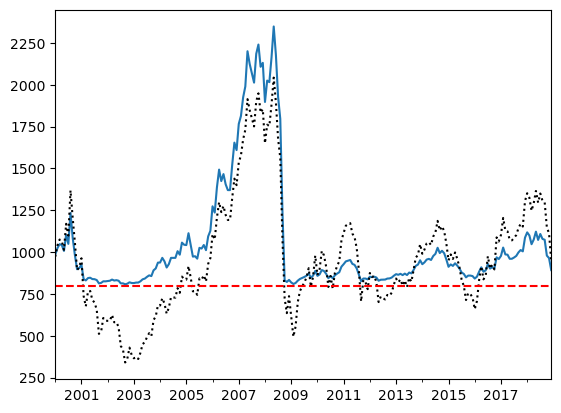

In [19]:
ind = "Steel"
ax = account_history[ind].plot()
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value,color ="r", linestyle="--")

In [20]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [24]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


<AxesSubplot:>

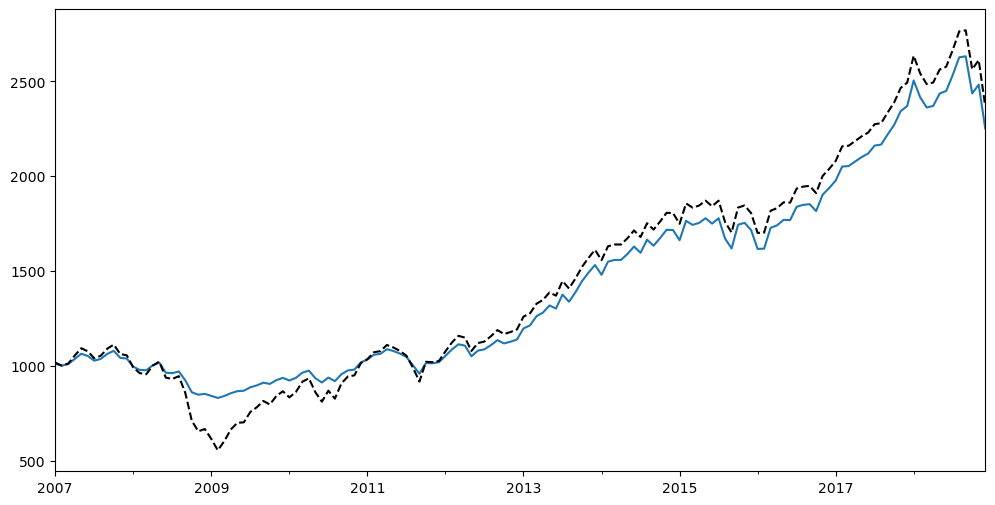

In [25]:
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(figsize=(12,6), legend=False)
btr["Risky Wealth"].plot(ax=ax, style="k--", legend=False)

In [26]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [27]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


In [29]:
btr = erk.run_cppi(ind_return["2007":][["Steel","Fin","Beer"]], drawdown= 0.25)

<AxesSubplot:>

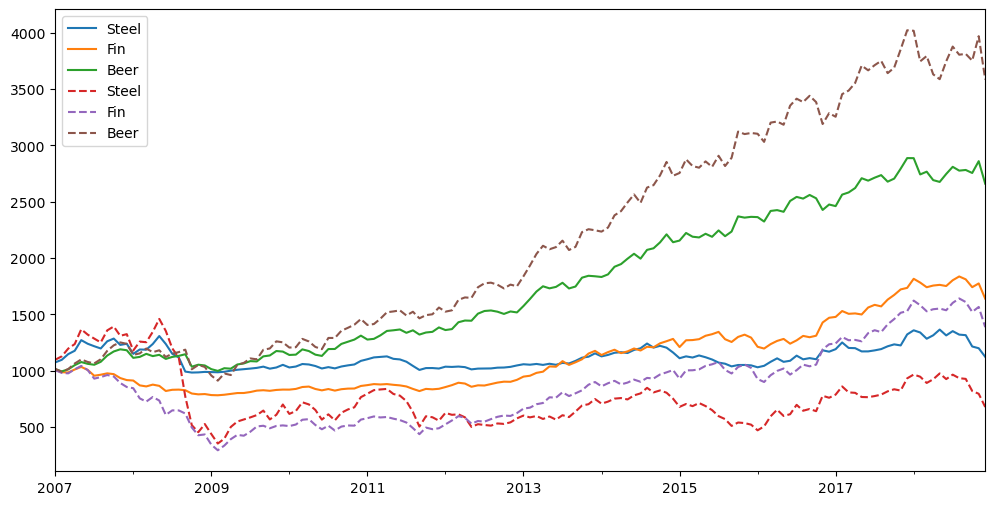

In [31]:
ax = btr["Wealth"].plot(figsize=(12,6))
btr["Risky Wealth"].plot(ax = ax, style="--")

In [33]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [34]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
